# Load NATL60 data on a dask cluster via xarray, time spectral analysis

Inspiration from Ryan's [notebook](https://github.com/rabernat/dask_distributed_demo/blob/master/notebooks/petascale_postprocessing_presentation.ipynb)


---

## Connect to dask cluster

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from glob import glob

import xrft

from dask.dot import dot_graph
from dask.array import from_array
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics import visualize


In [2]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client
#print(client)
#print(client._repr_html_())

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


Client Scheduler: tcp://10.148.1.4:8786 Dashboard: http://10.148.1.4:8787,Cluster Workers: 48 Cores: 192 Memory: 480.00 GB


---

## Open dataset


In [3]:
dpath='/home/datawork-lops-osi/data/natl60/NATL60-CJM165/1d/3D/'
filenames = sorted(glob(dpath+'*_gridT.nc'))
print('Number of files available: %d' %len(filenames))

filenames = filenames[:2] # for graph purpose
print('Number of files processed: %d' %len(filenames))

Number of files available: 365
Number of files processed: 2


---

## chunk after open_mfdataset data

In [4]:
%time v = xr.open_mfdataset(filenames, concat_dim='time_counter', compat='equals')['votemper']
print(v)

CPU times: user 372 ms, sys: 484 ms, total: 856 ms
Wall time: 2.61 s
<xarray.DataArray 'votemper' (time_counter: 2, deptht: 300, y: 3454, x: 5422)>
dask.array<shape=(2, 300, 3454, 5422), dtype=float64, chunksize=(1, 300, 3454, 5422)>
Coordinates:
  * deptht         (deptht) float32 0.480455 1.55879 2.79421 4.18731 5.73867 ...
    nav_lat        (y, x) float32 26.5648 26.5648 26.5648 26.5648 26.5648 ...
    nav_lon        (y, x) float32 -81.4512 -81.4346 -81.4179 -81.4012 ...
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(2,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2012-10-01T12:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 40 s)


In [5]:
#dot_graph(v.data.dask)

votemper dask.array<rechunk-merge, shape=(2, 300, 3454, 5422), dtype=float64, chunksize=(2, 100, 3454, 5422)>


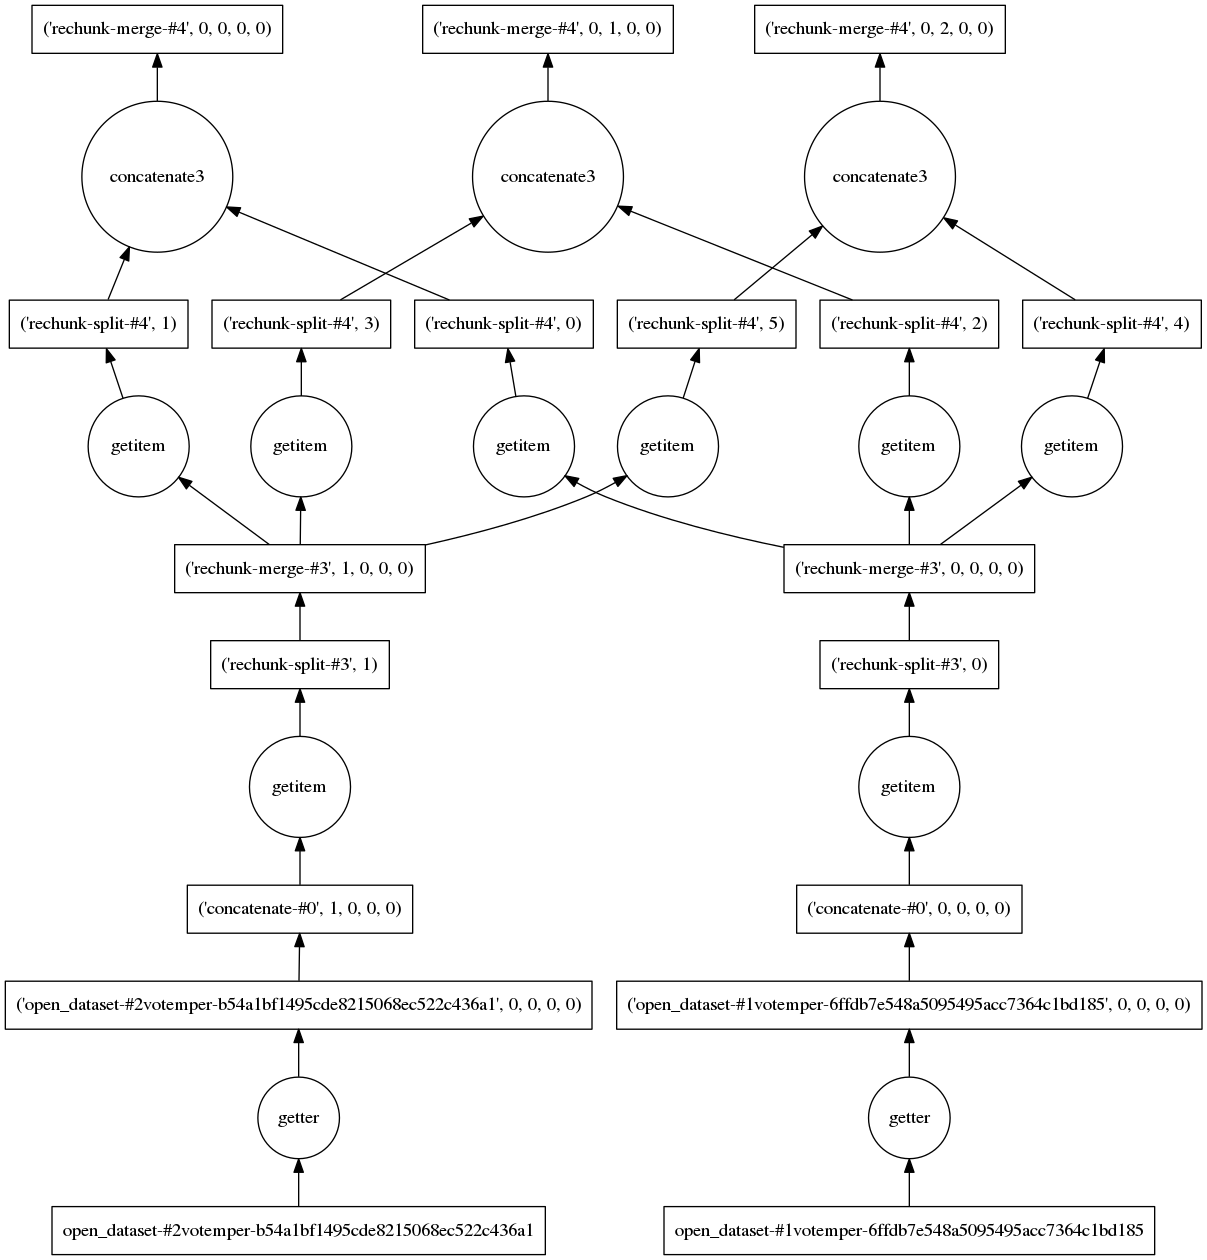

In [6]:
chunks={'time_counter': 2, 'deptht': 100}
v=v.chunk(chunks)
print(v.name, v.data)
dot_graph(v.data.dask)

---

## chunking at open_mfdataset stage

In [7]:
chunks={'deptht': 100}
%time v = xr.open_mfdataset(filenames, concat_dim='time_counter', chunks=chunks, compat='equals')['votemper']
print(v.name, v.data)
#dot_graph(v.data.dask)

CPU times: user 356 ms, sys: 452 ms, total: 808 ms
Wall time: 2.62 s
votemper dask.array<concatenate, shape=(2, 300, 3454, 5422), dtype=float64, chunksize=(1, 100, 3454, 5422)>


votemper dask.array<rechunk-merge, shape=(2, 300, 3454, 5422), dtype=float64, chunksize=(2, 100, 3454, 5422)>


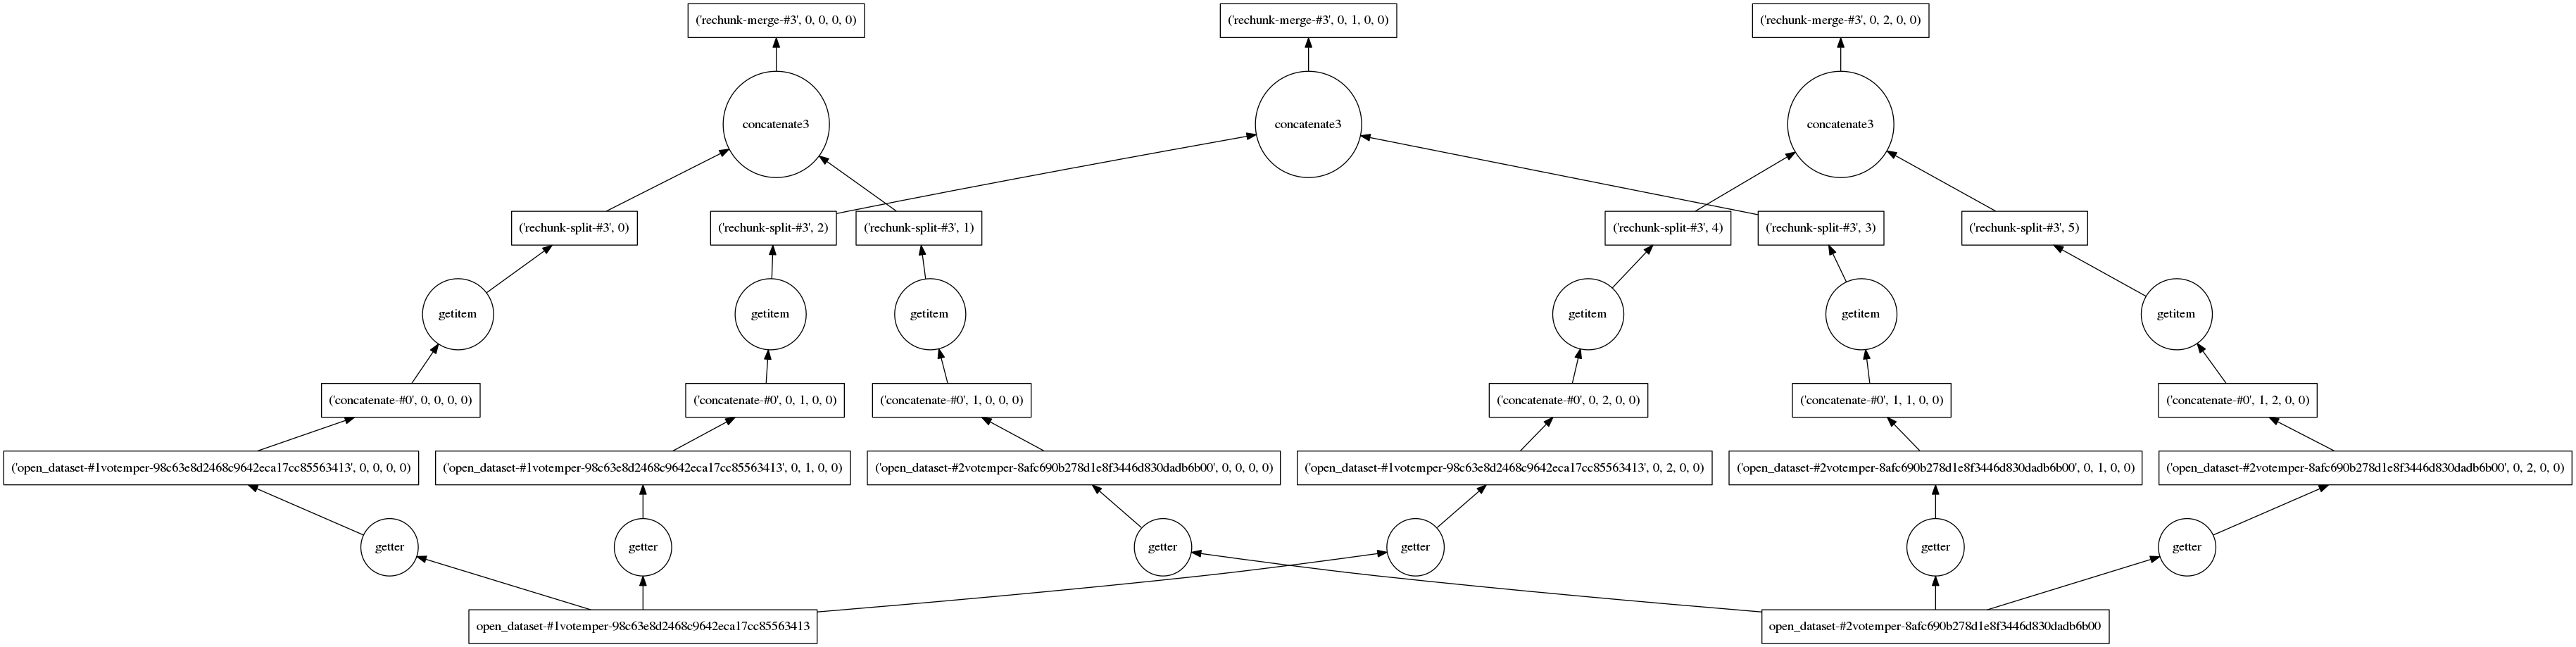

In [8]:
chunks={'time_counter': 2, 'deptht': 100}
v=v.chunk(chunks)
print(v.name, v.data)
dot_graph(v.data.dask)